In [1]:
from keras import layers

from models import create_model
from models.layers import RandomSwitch
from utils.data import from_dir, over_sampling, random_resample, from_zip

data_path = 'data/chest_xray/train'

2025-02-20 21:12:14.950568: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 21:12:14.950860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 21:12:14.952400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-20 21:12:14.956423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740082334.963206  158141 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740082334.96

In [2]:
resize = (96, 96)

In [3]:
training_selector = lambda s: s.startswith('chest_xray/train/') and s.endswith('.jpeg')
(x, y) = from_dir(data_path, resize=resize, resample=random_resample)

In [4]:
NEG_IDX = 0
POS_IDX = 1
TOTAL   = len(y)
N       = len(list(filter(lambda j: j == 0, y)))
P       = len(list(filter(lambda j: j == 1, y)))
print(f'#Positives = {P} ({P/TOTAL*100:.2f}%)')
print(f'#Negatives = {N} ({N/TOTAL*100:.2f}%)')

#Positives = 3883 (74.22%)
#Negatives = 1349 (25.78%)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=42)
total_train = len(Y_train)
N_train     = len(list(filter(lambda j: j == 0, Y_train)))
P_train     = len(list(filter(lambda j: j == 1, Y_train)))
print(f'#Positives (train) = {P_train} ({P_train/total_train*100:.2f}%)')
print(f'#Negatives (train) = {N_train} ({N_train/total_train*100:.2f}%)')
total_val   = len(Y_val)
N_val       = len(list(filter(lambda j: j == 0, Y_val)))
P_val       = len(list(filter(lambda j: j == 1, Y_val)))
print(f'#Positives (val)   = {P_val} ({P_val/total_val*100:.2f}%)')
print(f'#Negatives (val)   = {N_val} ({N_val/total_val*100:.2f}%)')

#Positives (train) = 3095 (73.95%)
#Negatives (train) = 1090 (26.05%)
#Positives (val)   = 788 (75.26%)
#Negatives (val)   = 259 (24.74%)


In [6]:
xs_extras, ys_extras = over_sampling(X_train, Y_train)
total   = len(ys_extras)
N_extras       = len(list(filter(lambda j: j == 0, ys_extras)))
P_extras       = len(list(filter(lambda j: j == 1, ys_extras)))
print(f'#Positives (val)   = {P_extras} ({P_extras/total*100:.2f}%)')
print(f'#Negatives (val)   = {N_extras} ({N_extras/total*100:.2f}%)')

#Positives (val)   = 3095 (50.00%)
#Negatives (val)   = 3095 (50.00%)


In [7]:
tr = layers.RandomTranslation(0.2, 0.2, data_format='channels_last')
rr = layers.RandomRotation(0.2, data_format='channels_last')
rb = layers.RandomBrightness(0.2, data_format='channels_last')
rc = layers.RandomContrast(0.2, data_format='channels_last')
rz = layers.RandomZoom(0.2, 0.2, data_format='channels_last')
data_augmentation = RandomSwitch([tr, rr, rb, rc, rz], 0.7)

2025-02-20 21:12:18.019429: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
v1 = create_model('alex-net', resize=resize)

In [9]:
from keras import losses, metrics, optimizers

METRICS = [
    metrics.BinaryCrossentropy(name='cross entropy'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
    metrics.AUC(name='prc', curve='PR')
]

v1.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), metrics=METRICS)
v1.summary()

Model: "sequential_with_threshold"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 96, 96, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline (Pipeline)             │ (None, 22, 22, 96)     │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline_1 (Pipeline)           │ (None, 10, 10, 256)    │       615,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline_2 (Pipeline)           │ (None, 4, 4, 384)      │       886,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline_3 (Pipeline)           │ (None, 4, 4, 384)      │     1,329,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pipeline_4 (Pipeline)           │ (None, 4, 4, 256)      │       886,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,567,556 (82.27 MB)

 Trainable params: 21,564,801 (82.26 MB)

 Non-trainable params: 2,755 (10.77 KB)

In [10]:
from keras import callbacks

EPOCHS = 1
BATCH_SIZE = 32
early_stopping = callbacks.EarlyStopping(
    verbose=1,
    patience=10,
    restore_best_weights=True)

In [11]:
v1.set_threshold(0.4995)
pred = v1.predict(X_train, batch_size=BATCH_SIZE)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(Y_val, Y_pred):
    def flatten(y):
        return np.array(list(map(lambda x: 0 if x[0] > x[1] else 1, y)))
    result = confusion_matrix(Y_val, Y_pred, normalize='pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['NORMAL', 'PNEUMONIA'])
    disp.plot()

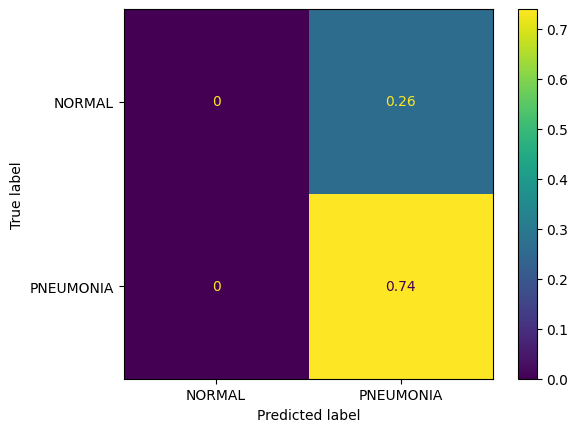

In [43]:
plot_confusion_matrix(Y_train, pred)

In [17]:
print(Y_train.shape)
print(pred[0])
print(pred[40:60])

(4185, 1)
0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
history = v1.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, Y_val),
    validation_freq=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - auc: 0.8250 - cross entropy: 0.8432 - loss: 0.8432 - prc: 0.9088 - recall: 0.8533 - val_auc: 0.5000 - val_cross entropy: 16.9255 - val_loss: 16.9255 - val_prc: 0.7526 - val_recall: 1.0000
Restoring model weights from the end of the best epoch: 1.
